# Street Sign Image Classification

## (A) Dependencies

In [ ]:
import numpy as np
import pandas
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

## (B) Data

### Downloading the dataset
- [Kaggle  Competition](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign)

In [1]:
# Download kaggle api
!pip install -q kaggle

In [2]:
# Creat the convenient dir for token. (The system will seach this dir)
! mkdir ~/.kaggle

- For create a token
  - Sign in your Kaggle account,
  - Open Account section from  your icon menu
  - Scroll to API section
  -  Click on __Create New API Token__
     - It will download kaggle.json file on your machine. 
  - Upload this kaggle.json file into your working directory on your google colab session.
  - Run floowing codes

In [7]:
# upload your kaggle token to download dataset.
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [8]:
# Copy the json file into correct path, then remove the firt one it
! cp kaggle.json ~/.kaggle/
! rm -f kaggle.json

In [9]:
# Set the token can't readable for other user if you save it somewhere
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
# Download your data "Competition-name"
#! kaggle competitions download -c 'competition-name'
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 611M/612M [00:04<00:00, 157MB/s]
100% 612M/612M [00:04<00:00, 151MB/s]


In [11]:
!unzip gtsrb-german-traffic-sign.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

In [12]:
!ls

gtsrb-german-traffic-sign.zip  Meta.csv     Test      Train
meta			       sample_data  Test.csv  Train.csv
Meta			       test	    train


### Loading the META csv data & Adjusting the dataset

In [13]:
import numpy as np

In [14]:
import pandas as pd

df_train = pd.read_csv("/content/Train.csv")
df_test = pd.read_csv("/content/Test.csv")

In [15]:
df_train.columns , all(df_train.columns == df_test.columns) 

(Index(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId',
        'Path'],
       dtype='object'),
 True)

In [16]:
df_te = df_test[["ClassId","Path"]]
df_tr = df_train[["ClassId","Path"]]

In [17]:
for i in df_tr[:4].values:
  print(i)

[20 'Train/20/00020_00000_00000.png']
[20 'Train/20/00020_00000_00001.png']
[20 'Train/20/00020_00000_00002.png']
[20 'Train/20/00020_00000_00003.png']


In [18]:
import os
import shutil


def move_files_into_dirs(data_dir:str,  meta_df:pd.DataFrame, new_meta_data_path="newTest.csv")->None:
  """It moves image files corresponding label directory 
  for setting the order of data into  tensorflow image reading convention. """
  
  # extracting the count of total class 
  max_class_id = meta_df["ClassId"].max()

  # creating class dirs to fill, ex: train/0, ..., train/n .
  for i in range(max_class_id+1):
    current_dir = os.path.join(data_dir, str(i))

    # if the path not exist create it.
    if not os.path.exists(current_dir):os.mkdir(current_dir) 
    


  # moving the image into class directory
  new_data_dict = {"ClassId":  [], "Path":[]}
  for class_id, image_path in meta_df.values:

    dir_sep = "/"
    class_dir_hierarchy = 1

    # creating new path to move image class dir
    parsed_path = image_path.split(sep=dir_sep)
    parsed_path.insert(class_dir_hierarchy, str(class_id))
    new_image_path = dir_sep.join(parsed_path)

    # Moving the image
    shutil.move(image_path, new_image_path)

    # collecting the new paths for creating meta csv_file
    new_data_dict["ClassId"].append(class_id)
    new_data_dict["Path"].append(new_image_path)
  
  df_new_meta_df = pd.DataFrame(new_data_dict)
  df_new_meta_df.to_csv(new_meta_data_path)


In [19]:
# Moving all the test data into its class dirs.
move_files_into_dirs(data_dir = "/content/Test", meta_df=df_te)

In [20]:
df_tr.head()

ClassId                            Path
0       20  Train/20/00020_00000_00000.png
1       20  Train/20/00020_00000_00001.png
2       20  Train/20/00020_00000_00002.png
3       20  Train/20/00020_00000_00003.png
4       20  Train/20/00020_00000_00004.png

### Data Labels

In [21]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

### Load the data 

In [22]:
import tensorflow as tf

#### Data Configurations

In [23]:
# Decleration of configuration variable
train_path = "/content/Train"
test_path = "/content/Test"

batch_size = 64
lr=0.01 # 0.001 #  =0.0001
      

In [24]:
#del train_ds, val_ds, test_ds

#### Loading the images form dirs

In [25]:
# loading &80 of train data as train
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  label_mode = "categorical",
  validation_split=0.2,
  seed=123,
  subset="training",
  batch_size=batch_size)

# loading &20 of train data as validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  label_mode = "categorical",
  validation_split=0.2,
  seed=123,
  subset="validation",
  batch_size=batch_size)

# loading test data
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_path,
  label_mode = "categorical",
  batch_size=batch_size)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.
Found 12630 files belonging to 43 classes.


### Visualating the data

#### Showing the images

In [26]:
train_coded_ids = train_ds.class_names

In [27]:
def decode_the_label(encoding_index, encoding=train_coded_ids):
  class_id = int( encoding[encoding_index] )
  class_name = classes[class_id]
  return class_name

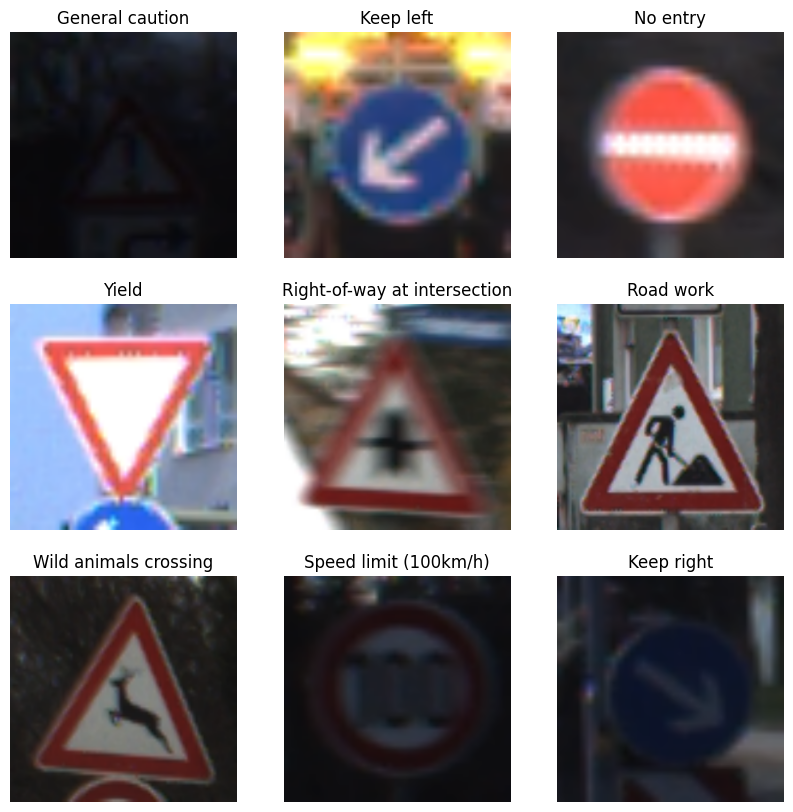

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, label_decoded_id in train_ds.take(1):
  for i in range(9):
    
    # finding out corresponding class name
    c = decode_the_label(encoding_index= np.argmax(label_decoded_id[i]) )
    img_shape = images[i].numpy().shape


    # plotting the image
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(c)
    plt.axis("off")

In [29]:
img_shape

(256, 256, 3)

#### Visualizing the frequencies

<Axes: xlabel='ClassId'>

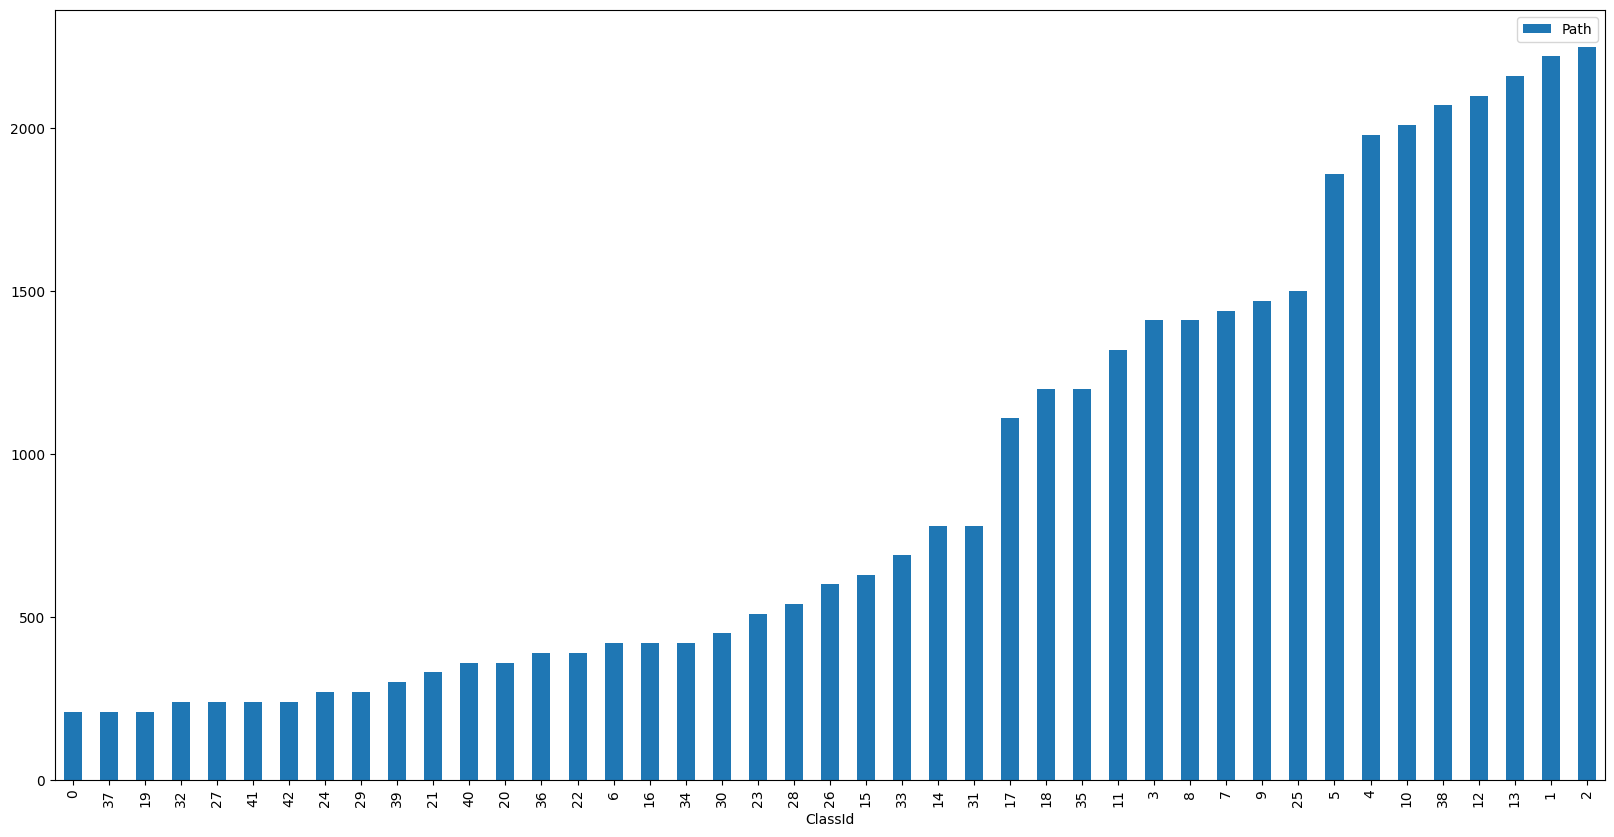

In [30]:
df_tr.groupby("ClassId").count().sort_values(by="Path").plot.bar(figsize=(20,10))

<Axes: ylabel='Path'>

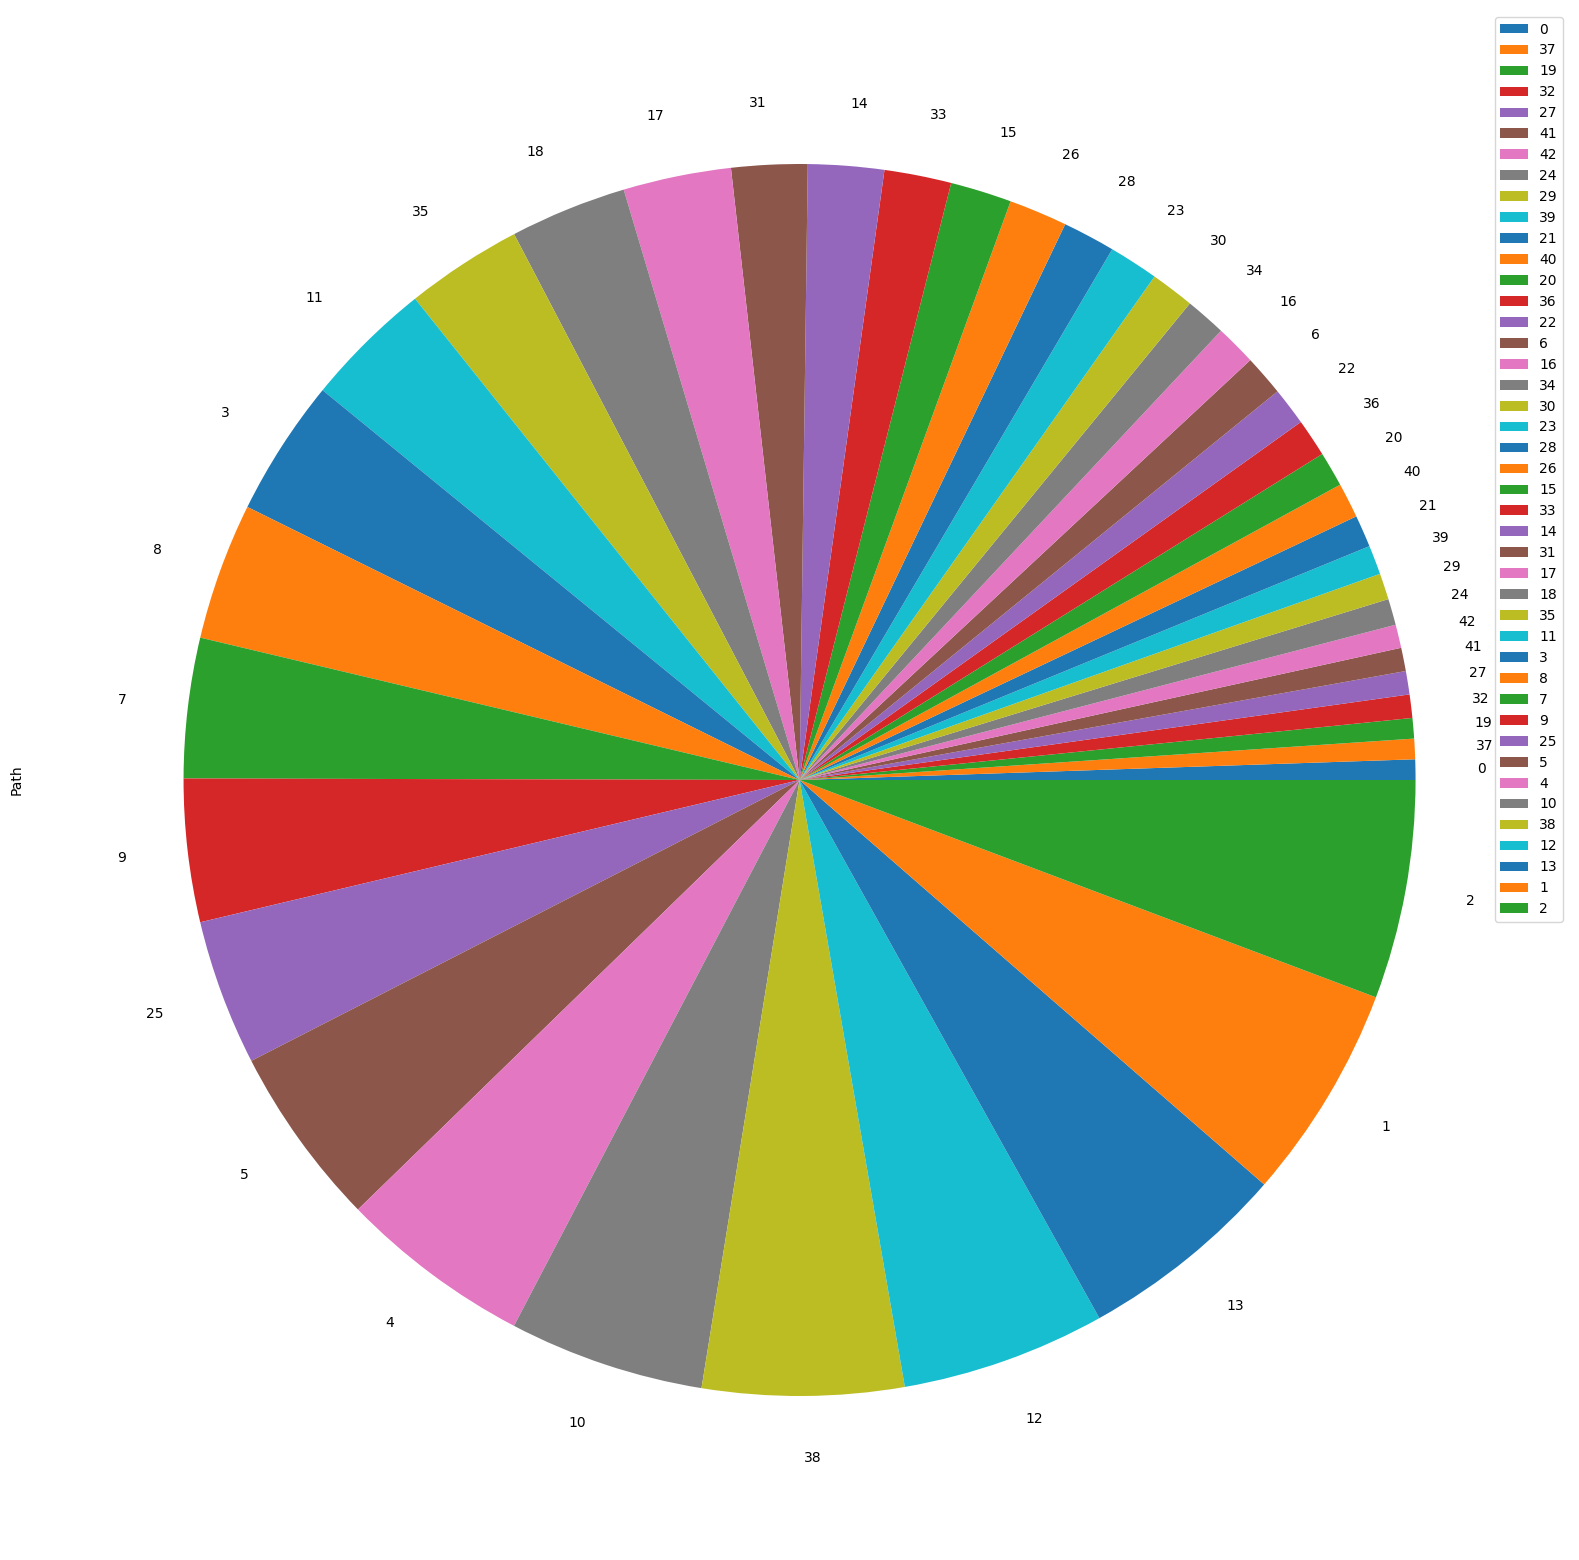

In [31]:
df_tr.groupby("ClassId").count().sort_values(by="Path").plot.pie(y="Path", figsize=(20,20))

<Axes: xlabel='ClassId'>

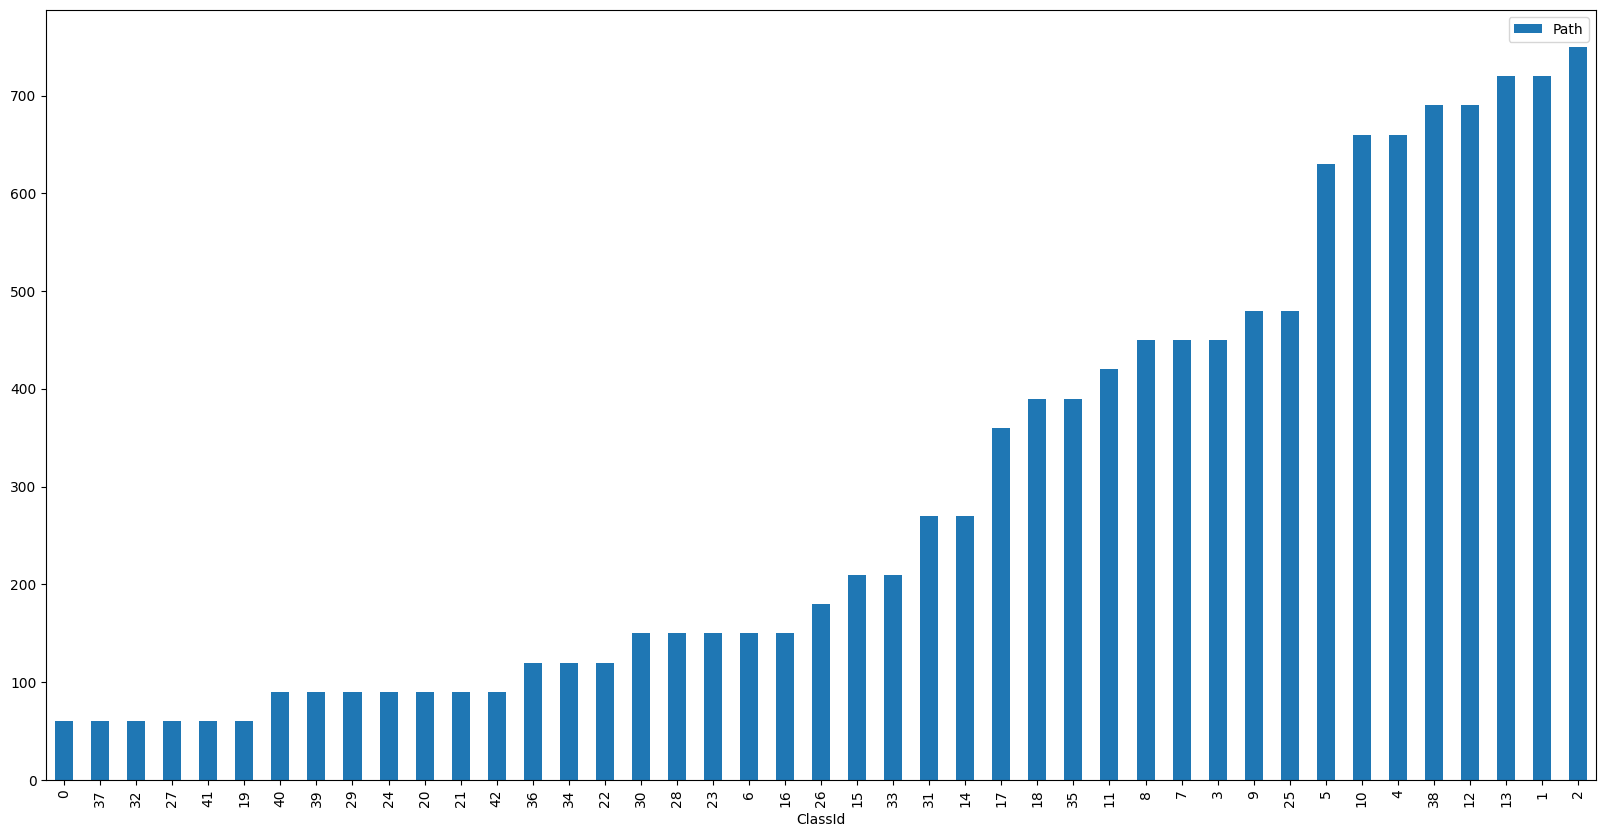

In [32]:
df_te.groupby("ClassId").count().sort_values(by="Path").plot.bar(figsize=(20,10))

<Axes: ylabel='Path'>

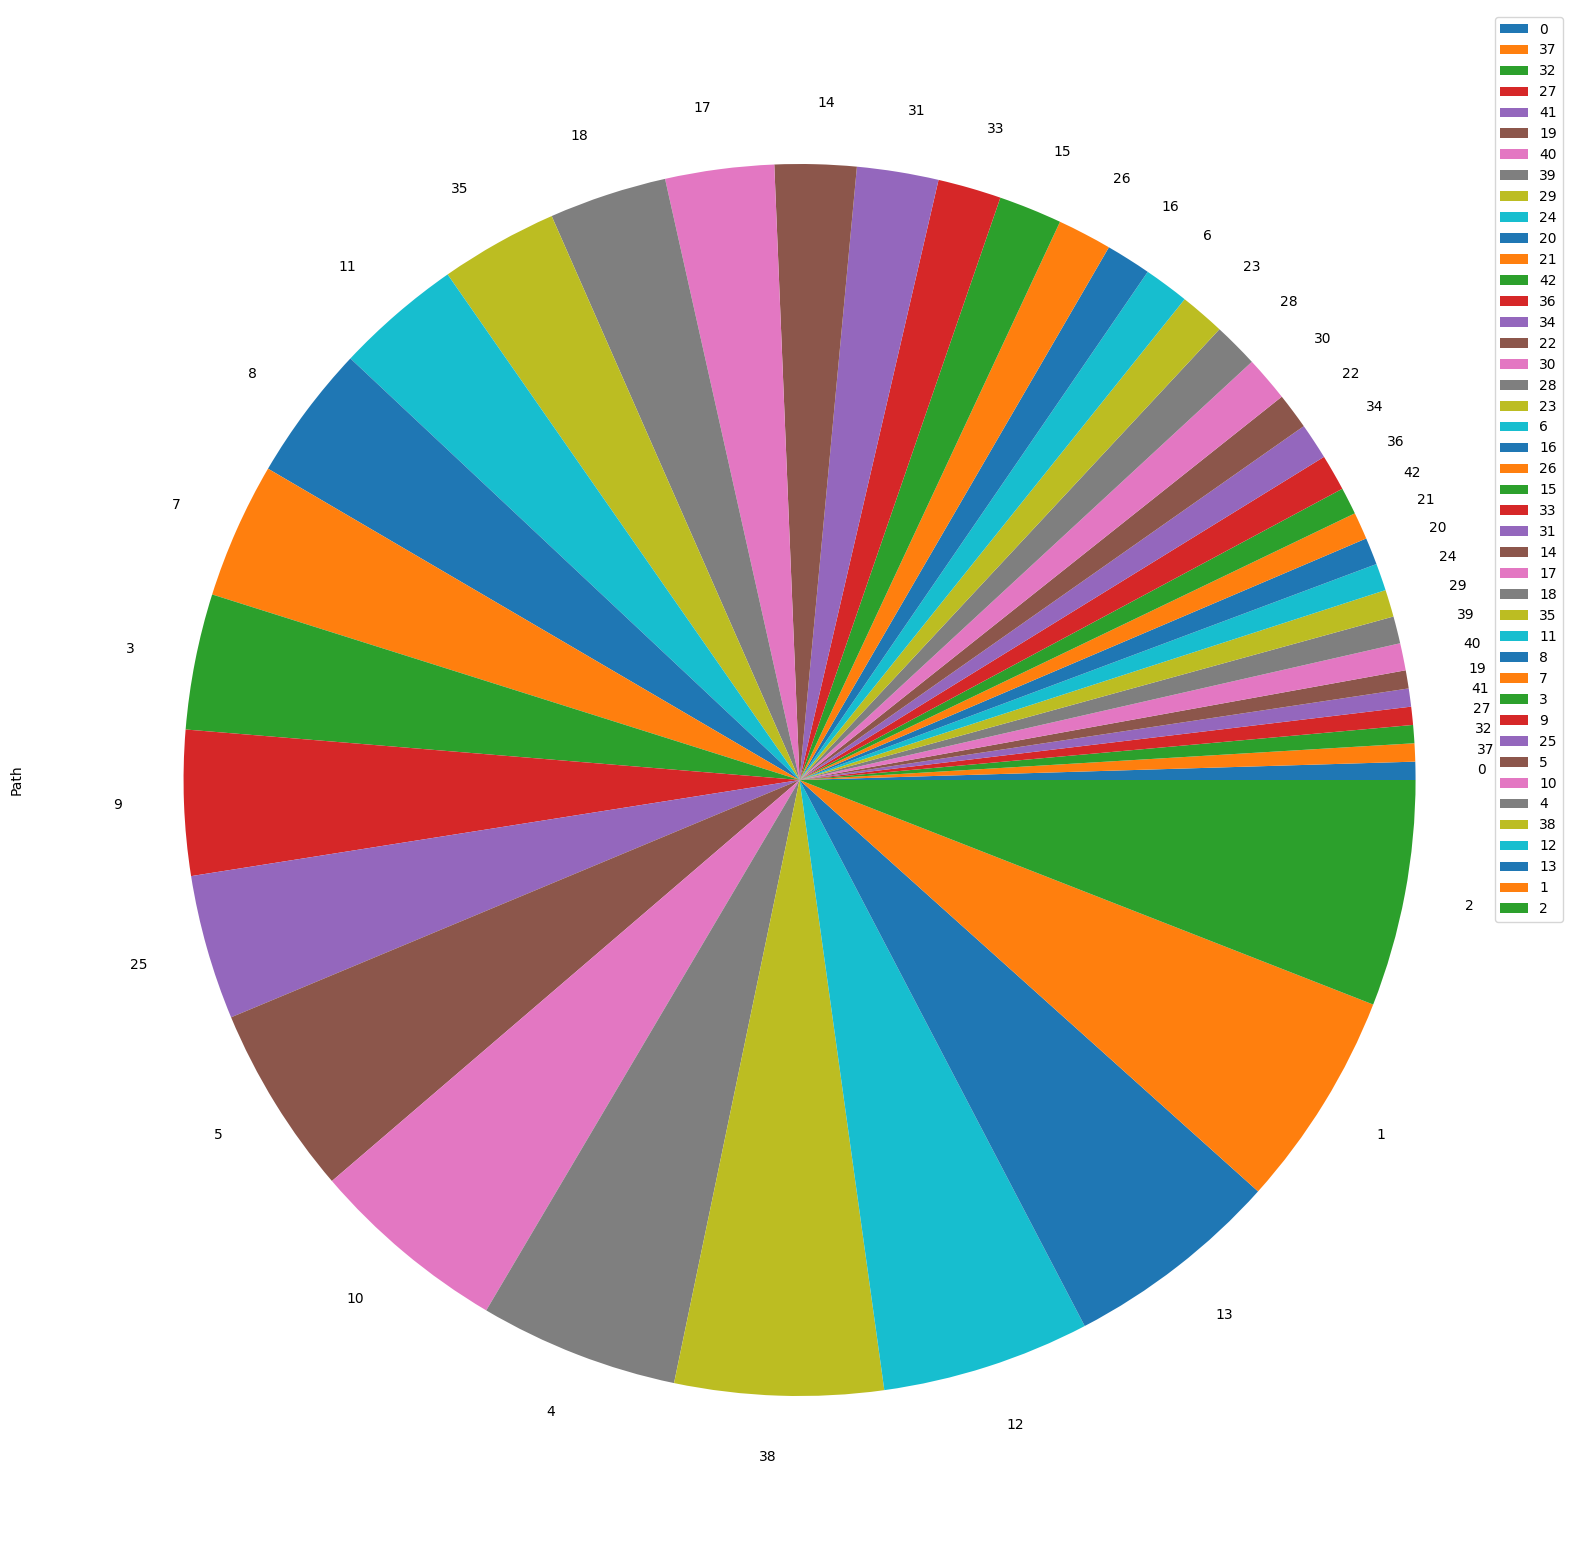

In [33]:
df_te.groupby("ClassId").count().sort_values(by="Path").plot.pie(y="Path", figsize=(20,20))

## (C) Pre-processing the dataset

#### Pre-processing 

In [34]:
def pre_processing(image, label, is_resize=True , new_size=(30, 30)):
  
  # scaling the images
  x = tf.keras.layers.Rescaling(1./255)(image)

  if is_resize:
    # resizing the image
    x = tf.image.resize(x, new_size)

  return x, label

#### Data Augmentation

In [35]:
from tensorflow.keras import layers

data_augmentation_layer_before_process = tf.keras.Sequential([
  #layers.RandomFlip("horizontal_and_vertical"), # it can confuse left and rigt
  layers.RandomCrop(height=256, width=256),
  layers.RandomRotation(0.01),
  layers.RandomZoom(0.2),
])

data_augmentation_layer = tf.keras.Sequential([
  #layers.RandomFlip("horizontal_and_vertical"), # it can confuse left and rigt
  layers.RandomCrop(height=30, width=30),
  layers.RandomRotation(0.01),
  layers.RandomZoom(0.2),
])

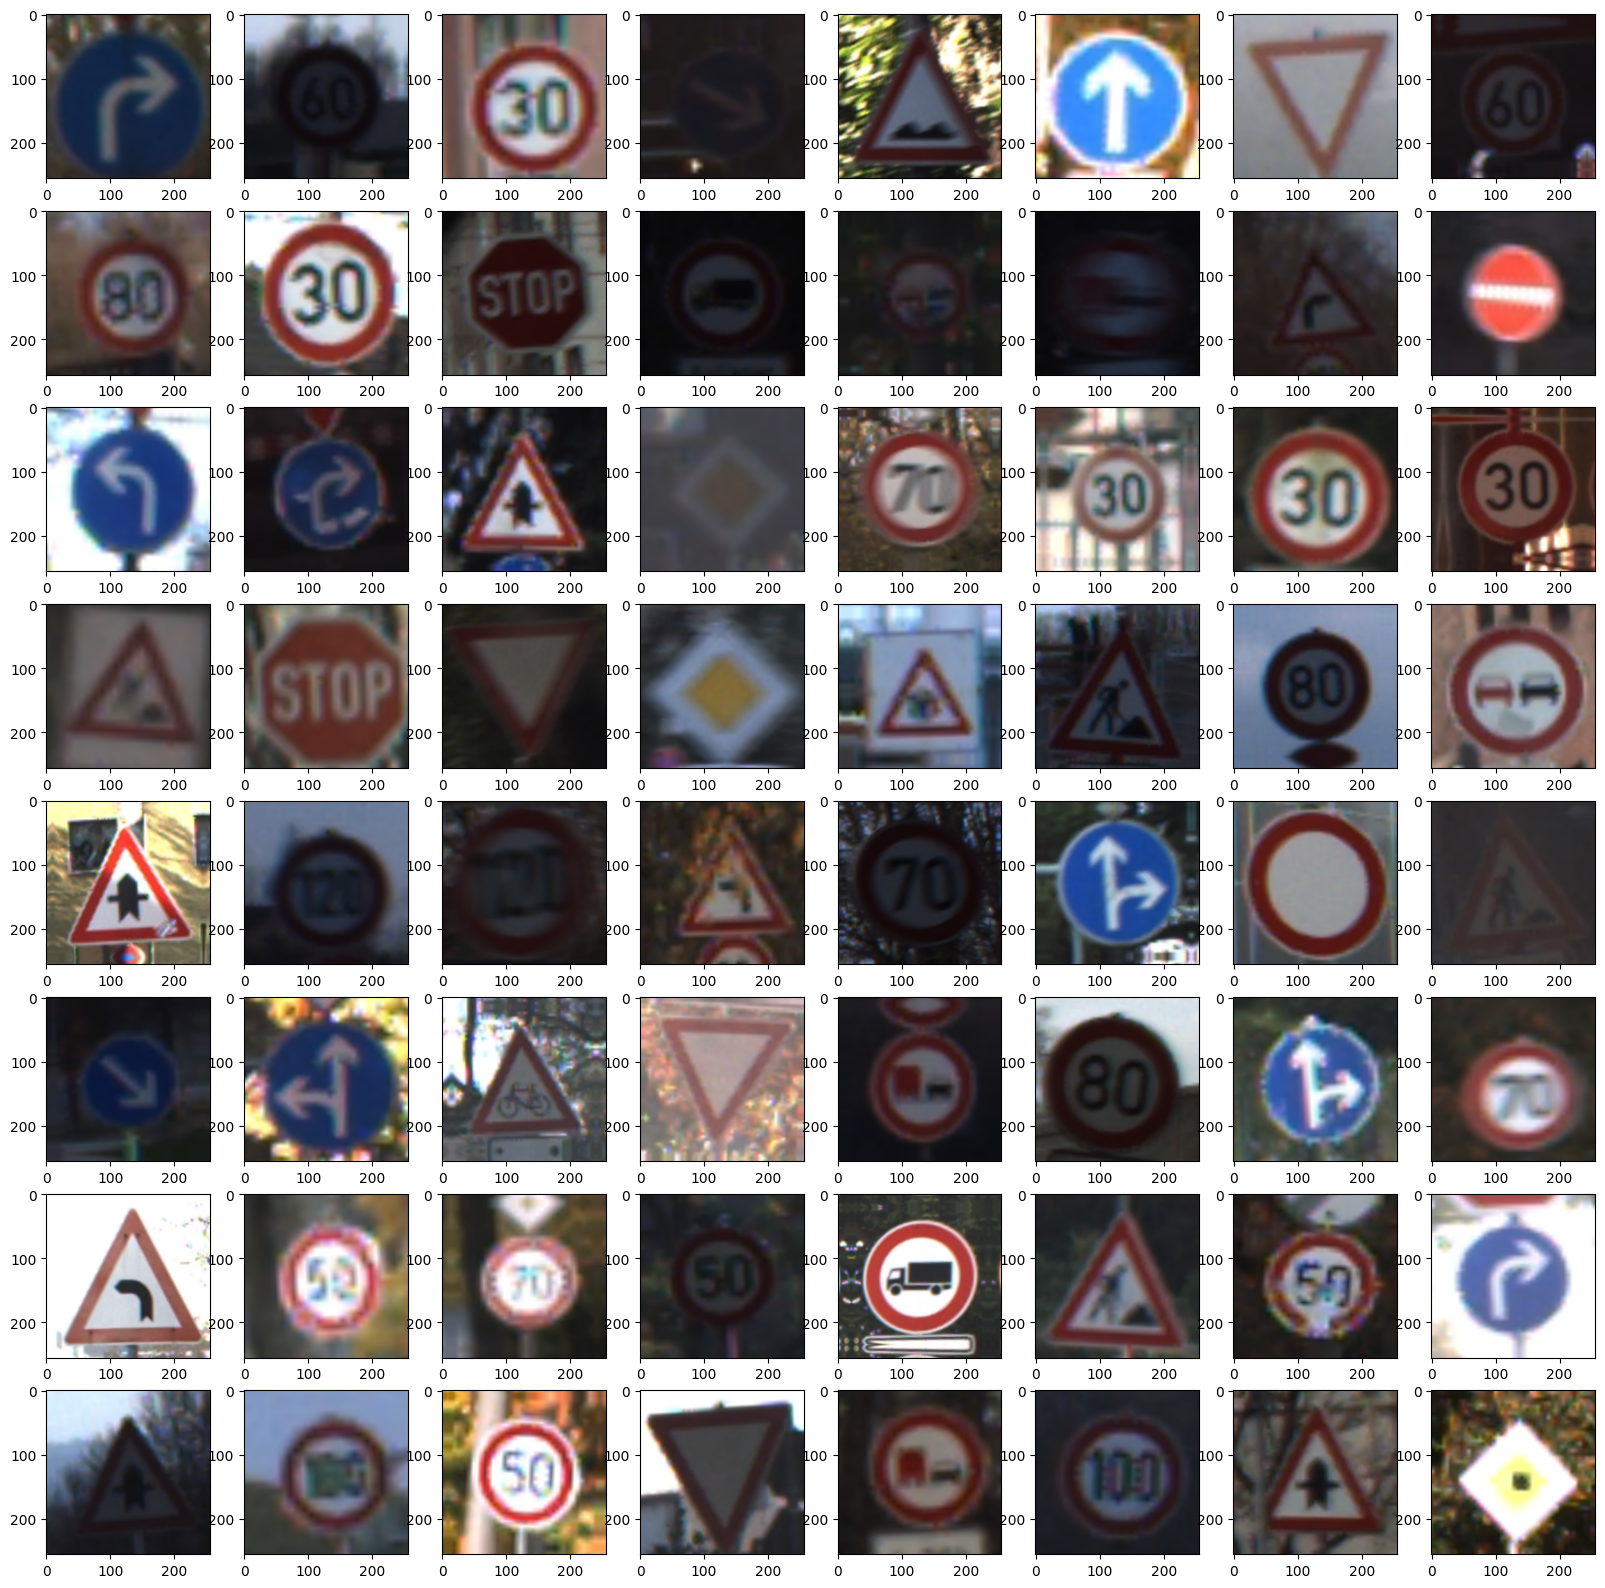

In [36]:
plt.figure(figsize=(20, 20))
for images, _ in train_ds.take(1):
    augmented_images = data_augmentation_layer_before_process(images)
    
    for i in range(len(augmented_images)):
      ax = plt.subplot(8,8 , i + 1)
      plt.imshow(augmented_images[i].numpy().astype("uint8"))

### Implementing the processes

In [37]:
# Pre-processing the data
train_ds = train_ds.map(pre_processing)
val_ds = val_ds.map(pre_processing)
test_ds = test_ds.map(pre_processing)

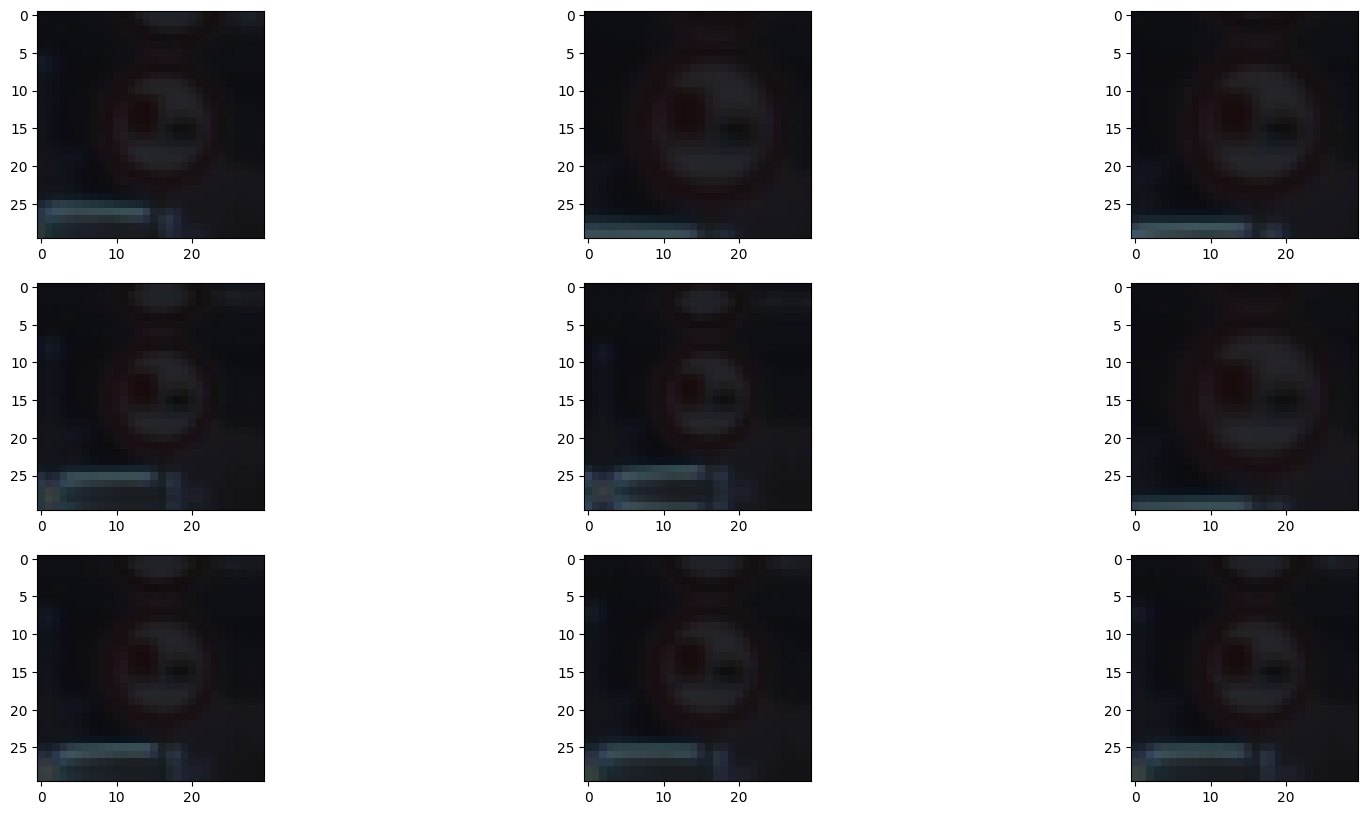

In [38]:
plt.figure(figsize=(20, 10))
for images, _ in train_ds.take(1):

    for i in range(9):
      
      augmented_images = data_augmentation_layer(images)
      ax = plt.subplot(3,3 , i + 1)
      plt.imshow(augmented_images[0])

#### Performance Configuration 

In [39]:
AUTOTUNE = tf.data.AUTOTUNE

# processing the dataset & performance configuration
train_ds = train_ds.shuffle(len(train_ds)).cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

## (D) Modelling

### Model Architectures

#### Building custom model from stractch

In [40]:
from keras.models import Sequential
from tensorflow.keras import layers, Model


# input layer
input = layers.Input(shape=(30,30,3))

# Augmentation layer, it just works at training time
x = data_augmentation_layer(input)

# basic Conv-block-1
x = layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu')(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Dropout(rate=0.25)(x)

# basic Conv-block-2
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Dropout(rate=0.25)(x)

# fully connected head
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(rate=0.5)(x)

# classifier from logit
output = layers.Dense(43, activation='softmax')(x)

# Setting the model data flow
model = Model(input, output) 

#Compilation of the model
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

# displaying the model architecture as string
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 30, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 30, 30, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                             

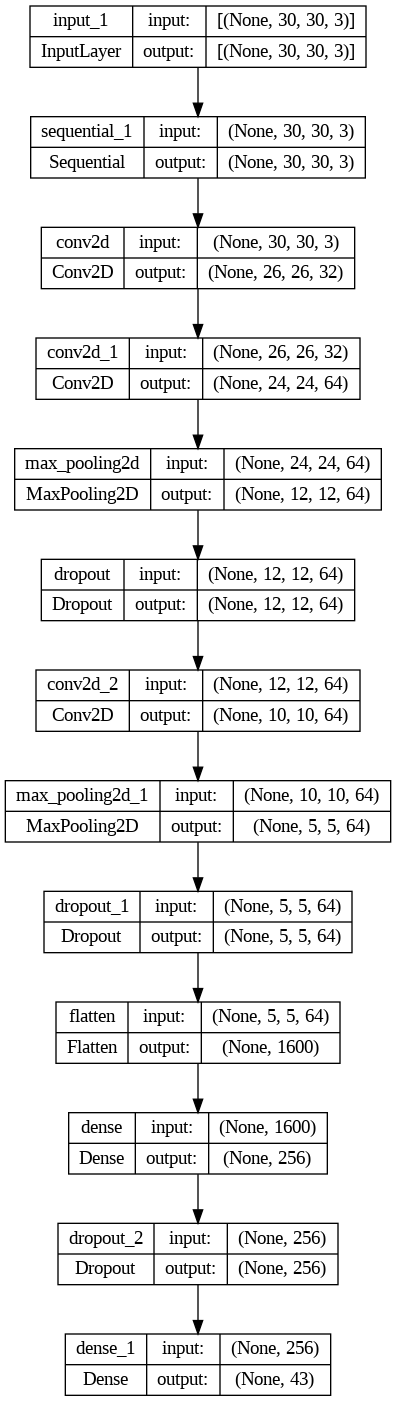

In [41]:
# visualizating the model architecture
tf.keras.utils.plot_model(model, show_shapes=True)

### Training

#### Callbacks

In [46]:
from datetime import datetime

def generate_path(path="", prefix="", suffix=""):
  now = datetime.now().strftime("%m-%d-%Y, %H:%M:%S")
  file_name = prefix + f"{now}" +"_{epoch:02d}-{val_loss:.2f}" + suffix

  return os.path.join(path, file_name)
  generate_path(prefix="Hello_")


def ckp_callback_generator():
  """ Saves individually"""

  def generate_path(path="", prefix="", suffix=""):
      now = datetime.now().strftime("%m-%d-%Y, %H:%M:%S")
      file_name = prefix + f"{now}" +"_{epoch:02d}-{val_loss:.2f}" + suffix
      
      return os.path.join(path, file_name)

  prefix, suffix = f"{model.name}_",  "_{epoch:02d}-{val_loss:.2f}" 
  checkpoint_filepath = './Models' #'/tmp/checkpoints'
  ckp_path = generate_path(path=checkpoint_filepath, prefix=prefix, suffix=suffix)
  save_freq='epoch'
  if not os.path.exists(checkpoint_filepath): os.mkdir(checkpoint_filepath)

  ckp_monitor = 'val_accuracy'
  ckp_mode = max
  #save_weights_only = True
  save_best_only = True

  pass

In [47]:
from datetime import datetime  

# Decleration of callback instance params


# Early Stopping
es_patiance = 5
es_monitor = 'val_loss'

# Tensorboard Logging save dir
tensorboard_log_dir ="./logs"

# check point save dir

prefix, suffix = f"{model.name}_",  "_{epoch:02d}-{val_loss:.2f}" 
checkpoint_filepath = './Models' #'/tmp/checkpoints'
ckp_path = generate_path(path=checkpoint_filepath, prefix=prefix, suffix=suffix)
save_freq='epoch'
if not os.path.exists(checkpoint_filepath): os.mkdir(checkpoint_filepath)

ckp_monitor = 'val_accuracy'
ckp_mode = max
#save_weights_only = True
save_best_only = True

# Learning Rate Schedular
def scheduler(epoch, lr): return  lr if epoch < 10 else  lr * tf.math.exp(-0.1)

In [48]:
# Instantiating callbacks
es_cb = tf.keras.callbacks.EarlyStopping(monitor=es_monitor, patience=es_patiance)

tb_cb =  tf.keras.callbacks.TensorBoard(log_dir=tensorboard_log_dir),

ckp_cb = tf.keras.callbacks.ModelCheckpoint( 
    filepath=ckp_path,  monitor=ckp_monitor, mode=ckp_mode, save_freq=save_freq, save_best_only=save_best_only)

lr_scheduler_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

# collecting all the callbacks
callbacks = [ es_cb, tb_cb, ckp_cb, lr_scheduler_cb ]

#### Traning

In [49]:
# training params
epochs = 100

In [50]:
history = model.fit(train_ds, epochs=epochs, batch_size=batch_size, validation_data=val_ds, callbacks=callbacks)

Epoch 1/100
491/491 [==============================] - ETA: 0s - loss: 1.7041 - accuracy: 0.5180

491/491 [==============================] - 79s 59ms/step - loss: 1.7041 - accuracy: 0.5180 - val_loss: 0.3628 - val_accuracy: 0.9131 - lr: 0.0010
Epoch 2/100
486/491 [============================>.] - ETA: 0s - loss: 0.4585 - accuracy: 0.8563

491/491 [==============================] - 7s 15ms/step - loss: 0.4569 - accuracy: 0.8568 - val_loss: 0.1216 - val_accuracy: 0.9693 - lr: 0.0010
Epoch 3/100
488/491 [============================>.] - ETA: 0s - loss: 0.2635 - accuracy: 0.9183

491/491 [==============================] - 9s 18ms/step - loss: 0.2628 - accuracy: 0.9185 - val_loss: 0.0691 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 4/100
486/491 [============================>.] - ETA: 0s - loss: 0.1880 - accuracy: 0.9402

491/491 [==============================] - 8s 17ms/step - loss: 0.1872 - accuracy: 0.9404 - val_loss: 0.0452 - val_accuracy: 0.9886 - lr: 0.0010
Epoch 5/100
486/491 [============================>.] - ETA: 0s - loss: 0.1478 - accuracy: 0.9555

491/491 [==============================] - 8s 17ms/step - loss: 0.1476 - accuracy: 0.9555 - val_loss: 0.0361 - val_accuracy: 0.9926 - lr: 0.0010
Epoch 6/100
488/491 [============================>.] - ETA: 0s - loss: 0.1225 - accuracy: 0.9618

491/491 [==============================] - 7s 15ms/step - loss: 0.1220 - accuracy: 0.9619 - val_loss: 0.0268 - val_accuracy: 0.9935 - lr: 0.0010
Epoch 7/100
487/491 [============================>.] - ETA: 0s - loss: 0.1101 - accuracy: 0.9661

491/491 [==============================] - 8s 17ms/step - loss: 0.1097 - accuracy: 0.9662 - val_loss: 0.0248 - val_accuracy: 0.9940 - lr: 0.0010
Epoch 8/100
491/491 [==============================] - 4s 9ms/step - loss: 0.0949 - accuracy: 0.9702 - val_loss: 0.0254 - val_accuracy: 0.9936 - lr: 0.0010
Epoch 9/100
491/491 [==============================] - 5s 10ms/step - loss: 0.0826 - accuracy: 0.9749 - val_loss: 0.0248 - val_accuracy: 0.9936 - lr: 0.0010
Epoch 10/100
489/491 [============================>.] - ETA: 0s - loss: 0.0841 - accuracy: 0.9746

491/491 [==============================] - 9s 18ms/step - loss: 0.0839 - accuracy: 0.9747 - val_loss: 0.0203 - val_accuracy: 0.9953 - lr: 0.0010
Epoch 11/100
491/491 [==============================] - 4s 9ms/step - loss: 0.0685 - accuracy: 0.9787 - val_loss: 0.0208 - val_accuracy: 0.9945 - lr: 9.0484e-04
Epoch 12/100
487/491 [============================>.] - ETA: 0s - loss: 0.0608 - accuracy: 0.9805

491/491 [==============================] - 8s 17ms/step - loss: 0.0606 - accuracy: 0.9806 - val_loss: 0.0152 - val_accuracy: 0.9967 - lr: 8.1873e-04
Epoch 13/100
491/491 [==============================] - 4s 9ms/step - loss: 0.0507 - accuracy: 0.9844 - val_loss: 0.0205 - val_accuracy: 0.9952 - lr: 7.4082e-04
Epoch 14/100
491/491 [==============================] - 5s 10ms/step - loss: 0.0470 - accuracy: 0.9850 - val_loss: 0.0155 - val_accuracy: 0.9966 - lr: 6.7032e-04
Epoch 15/100
491/491 [==============================] - 4s 9ms/step - loss: 0.0409 - accuracy: 0.9870 - val_loss: 0.0166 - val_accuracy: 0.9964 - lr: 6.0653e-04
Epoch 16/100
489/491 [============================>.] - ETA: 0s - loss: 0.0420 - accuracy: 0.9868

491/491 [==============================] - 8s 17ms/step - loss: 0.0419 - accuracy: 0.9868 - val_loss: 0.0143 - val_accuracy: 0.9974 - lr: 5.4881e-04
Epoch 17/100
491/491 [==============================] - 4s 9ms/step - loss: 0.0350 - accuracy: 0.9891 - val_loss: 0.0147 - val_accuracy: 0.9969 - lr: 4.9659e-04
Epoch 18/100
488/491 [============================>.] - ETA: 0s - loss: 0.0342 - accuracy: 0.9888

491/491 [==============================] - 8s 17ms/step - loss: 0.0340 - accuracy: 0.9889 - val_loss: 0.0137 - val_accuracy: 0.9976 - lr: 4.4933e-04
Epoch 19/100
491/491 [==============================] - 5s 10ms/step - loss: 0.0331 - accuracy: 0.9895 - val_loss: 0.0124 - val_accuracy: 0.9971 - lr: 4.0657e-04
Epoch 20/100
491/491 [==============================] - 4s 9ms/step - loss: 0.0227 - accuracy: 0.9927 - val_loss: 0.0146 - val_accuracy: 0.9974 - lr: 3.6788e-04
Epoch 21/100
490/491 [============================>.] - ETA: 0s - loss: 0.0241 - accuracy: 0.9925

491/491 [==============================] - 9s 17ms/step - loss: 0.0241 - accuracy: 0.9925 - val_loss: 0.0147 - val_accuracy: 0.9977 - lr: 3.3287e-04
Epoch 22/100
487/491 [============================>.] - ETA: 0s - loss: 0.0244 - accuracy: 0.9925

491/491 [==============================] - 7s 15ms/step - loss: 0.0243 - accuracy: 0.9925 - val_loss: 0.0118 - val_accuracy: 0.9980 - lr: 3.0119e-04
Epoch 23/100
491/491 [==============================] - 5s 10ms/step - loss: 0.0230 - accuracy: 0.9929 - val_loss: 0.0124 - val_accuracy: 0.9977 - lr: 2.7253e-04
Epoch 24/100
491/491 [==============================] - 4s 9ms/step - loss: 0.0212 - accuracy: 0.9932 - val_loss: 0.0122 - val_accuracy: 0.9980 - lr: 2.4660e-04
Epoch 25/100
485/491 [============================>.] - ETA: 0s - loss: 0.0206 - accuracy: 0.9936

491/491 [==============================] - 8s 17ms/step - loss: 0.0204 - accuracy: 0.9937 - val_loss: 0.0117 - val_accuracy: 0.9981 - lr: 2.2313e-04
Epoch 26/100
491/491 [==============================] - 4s 9ms/step - loss: 0.0200 - accuracy: 0.9936 - val_loss: 0.0109 - val_accuracy: 0.9978 - lr: 2.0190e-04
Epoch 27/100
491/491 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9945

491/491 [==============================] - 8s 16ms/step - loss: 0.0165 - accuracy: 0.9945 - val_loss: 0.0119 - val_accuracy: 0.9983 - lr: 1.8268e-04
Epoch 28/100
491/491 [==============================] - 4s 9ms/step - loss: 0.0174 - accuracy: 0.9944 - val_loss: 0.0136 - val_accuracy: 0.9977 - lr: 1.6530e-04
Epoch 29/100
491/491 [==============================] - 5s 9ms/step - loss: 0.0161 - accuracy: 0.9948 - val_loss: 0.0122 - val_accuracy: 0.9977 - lr: 1.4957e-04
Epoch 30/100
491/491 [==============================] - 5s 10ms/step - loss: 0.0168 - accuracy: 0.9945 - val_loss: 0.0125 - val_accuracy: 0.9977 - lr: 1.3534e-04
Epoch 31/100
491/491 [==============================] - 4s 9ms/step - loss: 0.0159 - accuracy: 0.9948 - val_loss: 0.0123 - val_accuracy: 0.9981 - lr: 1.2246e-04


### Results

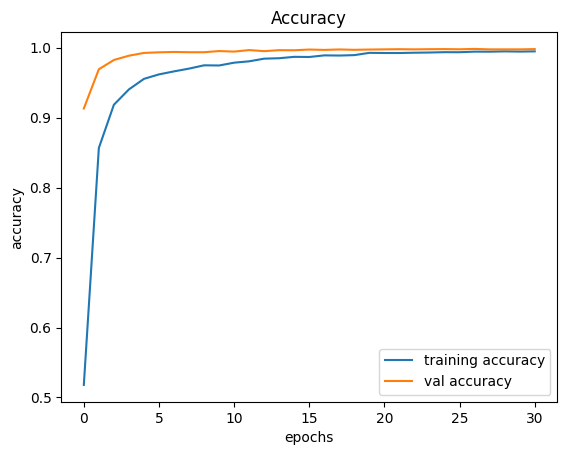

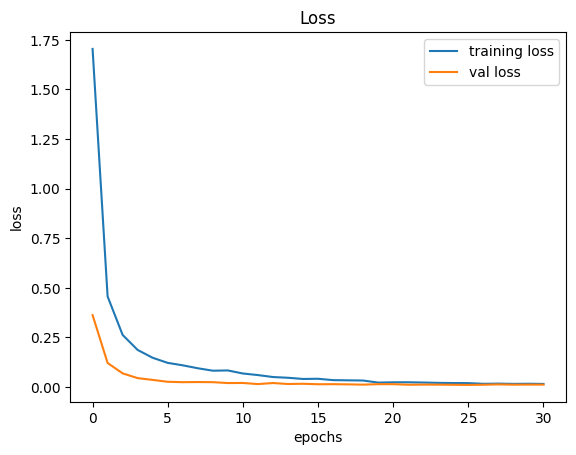

In [51]:
#Display of the accuracy and the loss values
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#### Saving the model

In [52]:
model.save("best_model")

### Predicting

In [53]:
predictions = model.predict(test_ds)

198/198 [==============================] - 16s 78ms/step


#### Formatting the predictions

In [54]:
predictions.shape

(12630, 43)

In [55]:
y_pred = np.argmax(predictions, axis=1)
y_pred

array([ 1, 32,  2, ..., 10, 16,  5])

#### Formatting the labels

In [56]:
test_labels= np.concatenate([y for x, y in test_ds], axis=0)

In [57]:
test_labels.shape

(12630, 43)

In [58]:
y_test = np.argmax(test_labels, axis=1)
y_test

array([ 1, 32,  2, ..., 10, 16,  5])

### Evaluating the results

In [61]:
best_model = tf.keras.models.load_model("best_model")

#### Evaluation Score

In [62]:
val_eval = model.evaluate(val_ds)
val_eval

123/123 [==============================] - 1s 4ms/step - loss: 0.0123 - accuracy: 0.9981


[0.012268561869859695, 0.9980869889259338]

In [63]:
test_eval = model.evaluate(test_ds)
test_eval

198/198 [==============================] - 1s 5ms/step - loss: 0.0904 - accuracy: 0.9797


[0.09042374044656754, 0.9797307848930359]

#### Confusion Matrix

In [64]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test, y_pred)

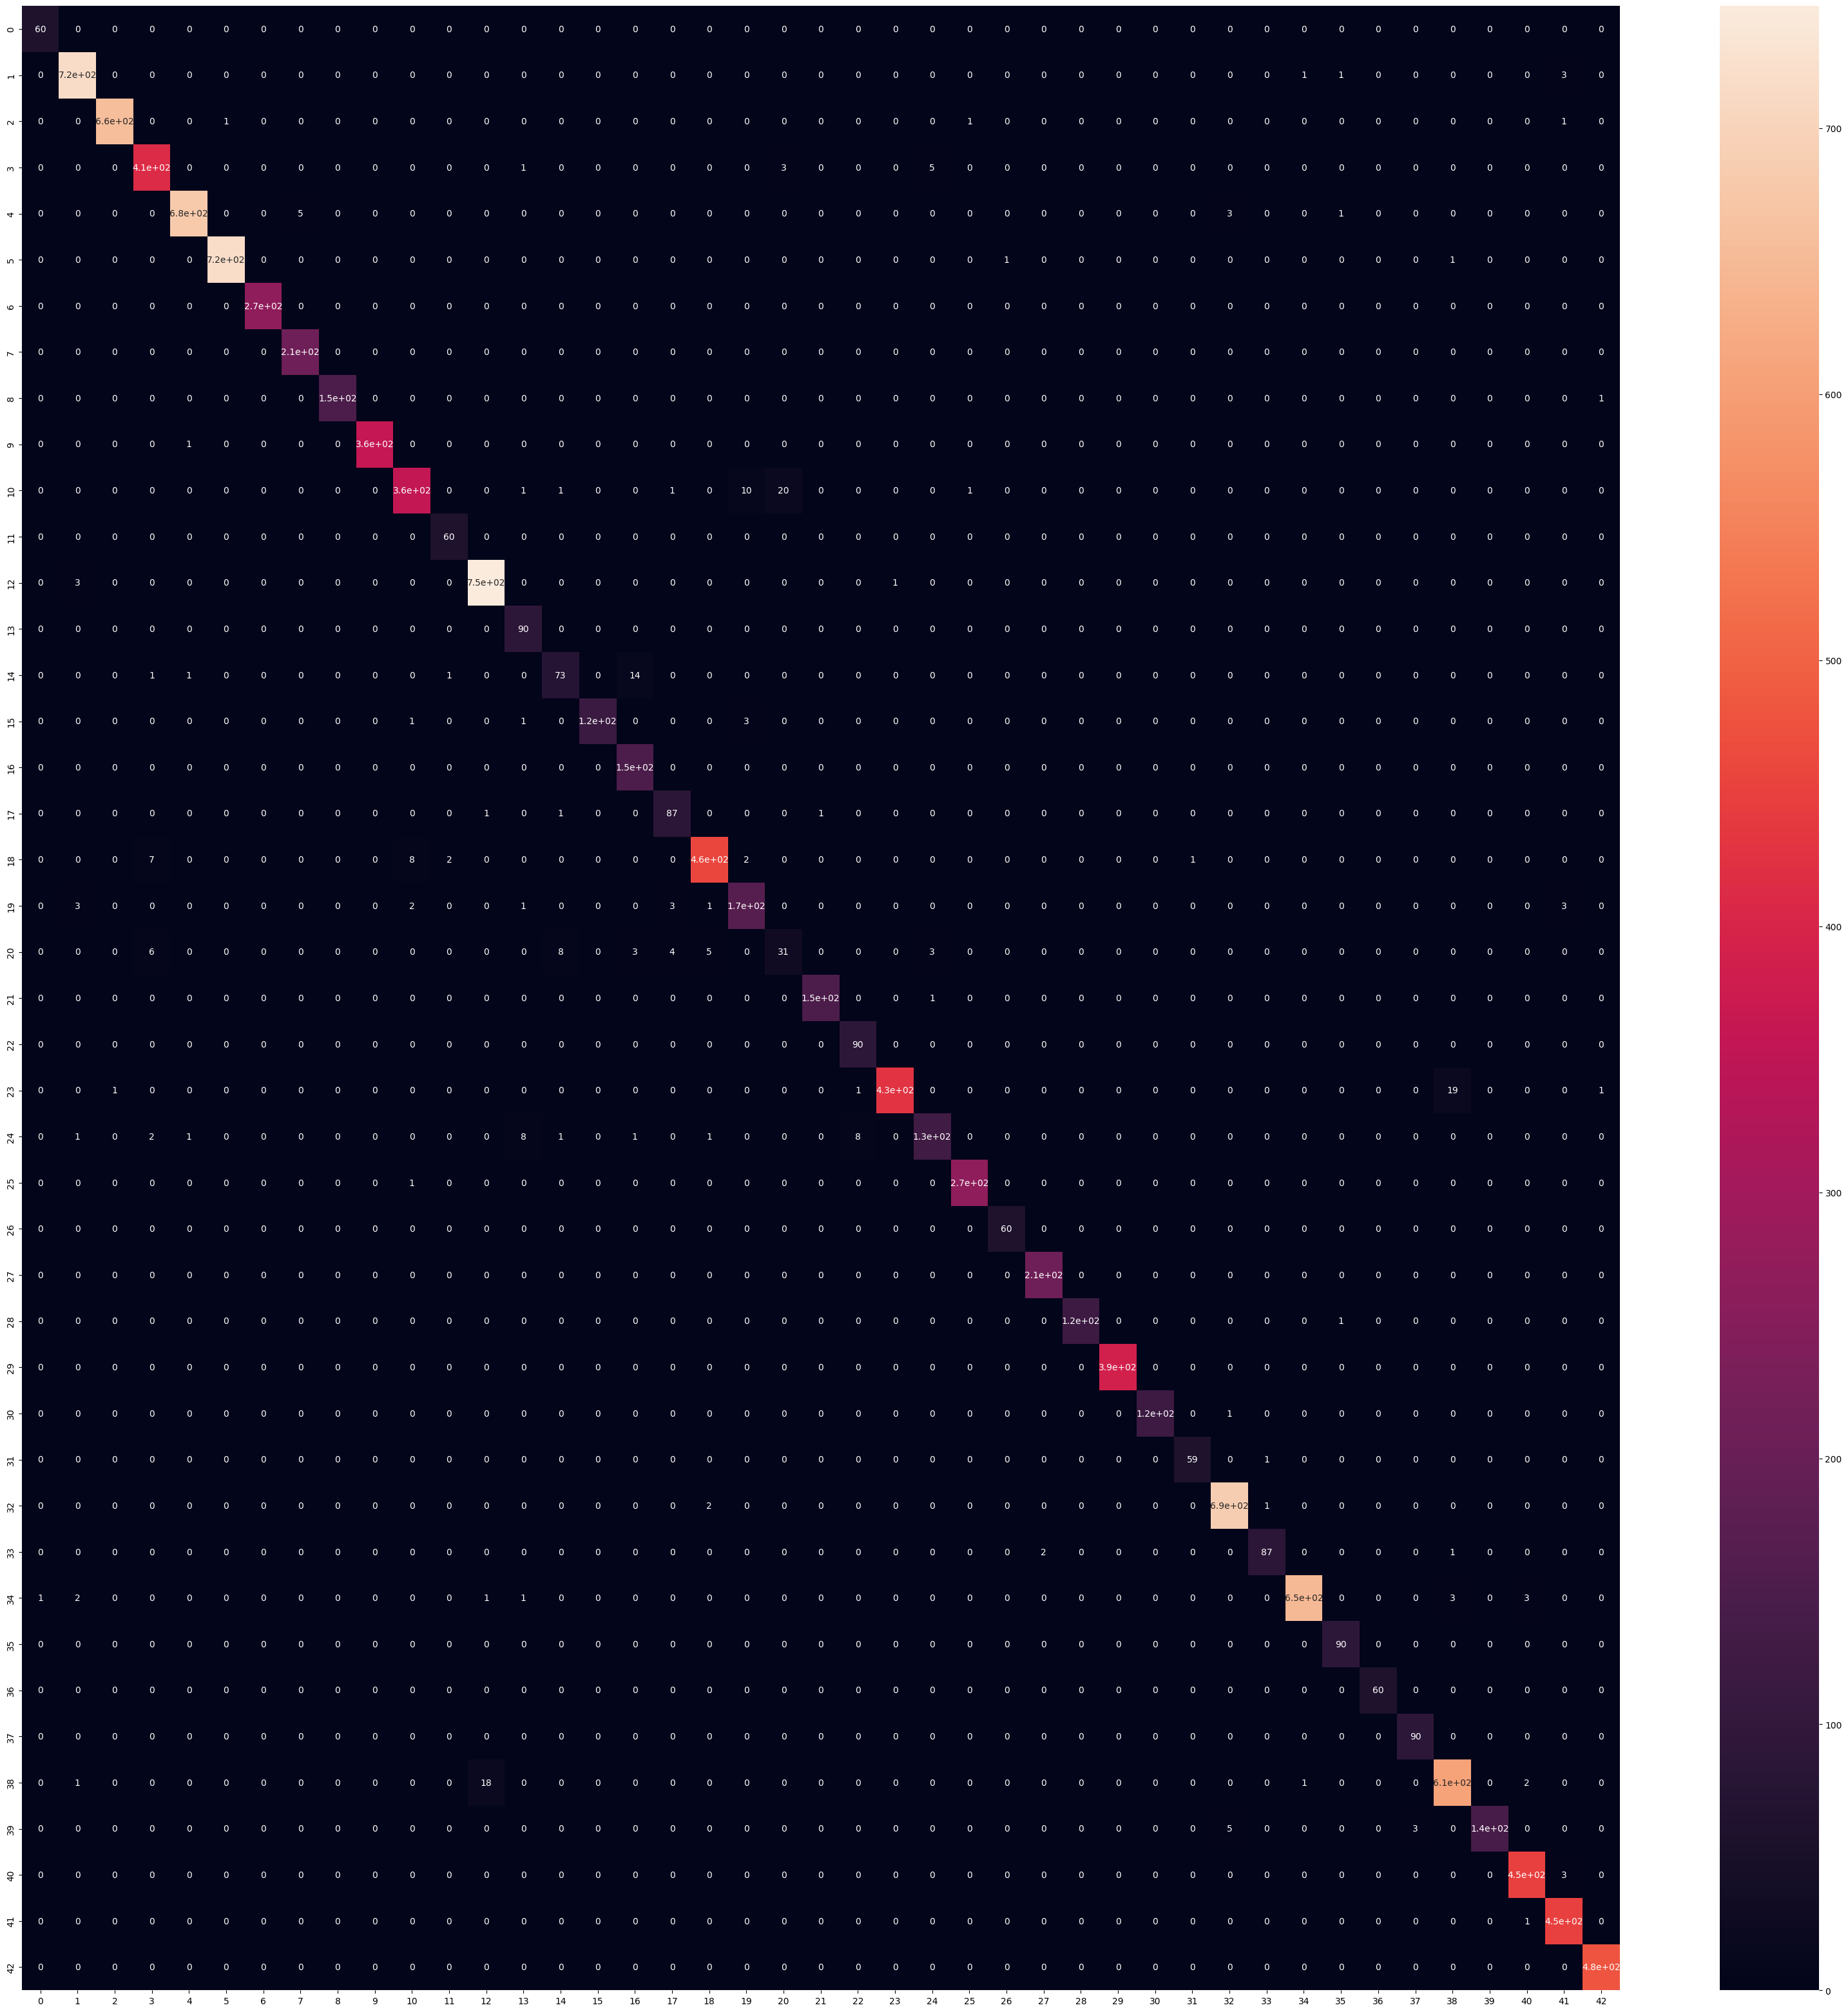

In [65]:
import seaborn as sns

# data casting
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)

#plotting the confusion matrix
plt.figure(figsize = (40,40))
sns.heatmap(df_cm, annot=True);

#### Classsification Report

In [66]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.99      0.99      0.99       720
           2       1.00      1.00      1.00       660
           3       0.96      0.98      0.97       420
           4       1.00      0.99      0.99       690
           5       1.00      1.00      1.00       720
           6       1.00      1.00      1.00       270
           7       0.98      1.00      0.99       210
           8       1.00      0.99      1.00       150
           9       1.00      1.00      1.00       360
          10       0.97      0.91      0.94       390
          11       0.95      1.00      0.98        60
          12       0.97      0.99      0.98       750
          13       0.87      1.00      0.93        90
          14       0.87      0.81      0.84        90
          15       1.00      0.96      0.98       120
          16       0.89      1.00      0.94       150
          17       0.92    

#### Visualizating the Prediction Images

In [67]:
demo_test_imgs= [x for x, y in test_ds.take(1)][0]
demo_test_labels = np.argmax(np.concatenate([y for x, y in test_ds.take(1)], axis=0), axis=1)
demo_test_preds = y_pred[:len(demo_test_labels)]

In [68]:
len(demo_test_imgs), demo_test_imgs[0].shape, len(demo_test_labels)

(64, TensorShape([30, 30, 3]), 64)

In [69]:
demo_size = int(batch_size/4)

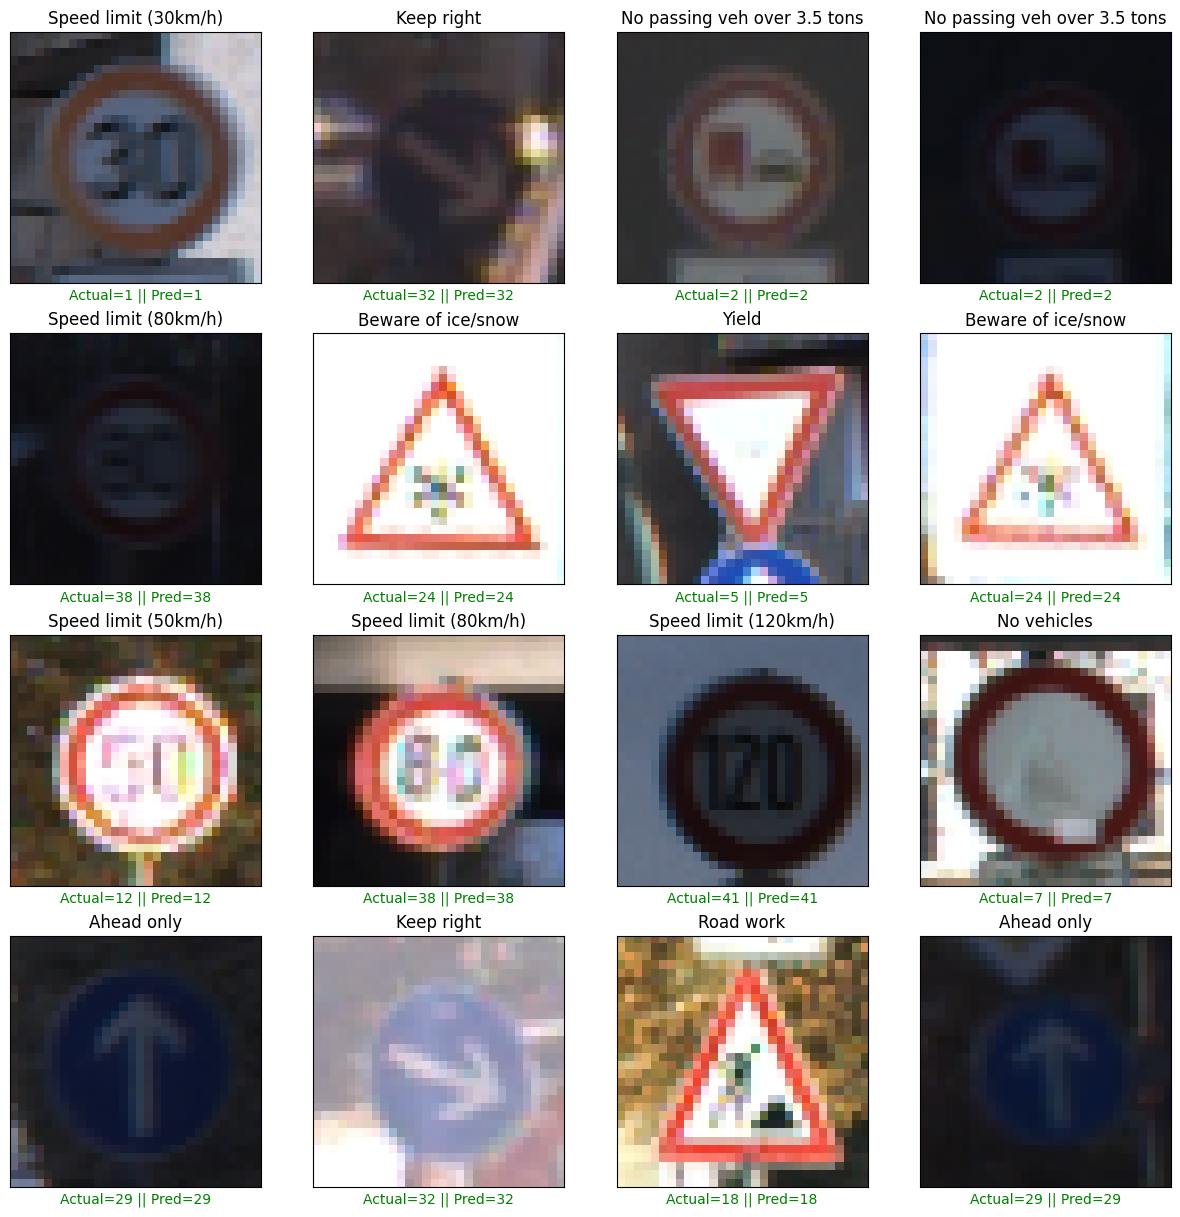

In [70]:
plt.figure(figsize = (15, 15))

start_index = 0

for i in range(demo_size):
    
    # creating a figure
    plt.subplot(4, 4, i + 1)
    
    # removing unnessesary plotting components for an image
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # getting the image 
    prediction = demo_test_preds[i]
    actual = demo_test_labels[i]
    
    # coloring the label of the image according to result
    col = 'r' if prediction != actual else 'g'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)

    # Writing the name of the class
    title = decode_the_label(actual)
    plt.title(title)

    # plotting the image
    plt.imshow(demo_test_imgs[i])
plt.show()

### Downloading the models

##### Select the model path

In [73]:
model_path = "best_model"

##### Zip the model

In [74]:
# Zipping via Bash code, if shutil didn't work
!zip -r "/content/best_model.zip" "/content/best_model"

  adding: content/best_model/ (stored 0%)
  adding: content/best_model/saved_model.pb (deflated 89%)
  adding: content/best_model/fingerprint.pb (stored 0%)
  adding: content/best_model/assets/ (stored 0%)
  adding: content/best_model/keras_metadata.pb (deflated 92%)
  adding: content/best_model/variables/ (stored 0%)
  adding: content/best_model/variables/variables.index (deflated 64%)
  adding: content/best_model/variables/variables.data-00000-of-00001 (deflated 12%)


#### Download the zipped file

In [75]:
from google.colab import files
# download the zipped file
files.download("best_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## (E) Deployment